In this notebook, the task is to wrangle and prepare two sets of dependent variabels.
The source of the data is Eurostat.

1st set: GENpac (generated packaging waste), RECpac_percent (packaging recycling rate)
2nd set: GENplas (generated plastic packaging waste), RECplas_percent (plastic packaging recycling rate)

In [24]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl 
from scipy.stats import skew, kurtosis

In [5]:


# read in the data from packaging waste
# each variable is in a separate sheet

file_path = 'packaging_waste.xlsx'

#dictionary {sheet_name: var name}
sheets = {'GENpac': 'GENpac',
          'RECpac': 'RECpac',
          'GENplas': 'GENplas',
          'RECplas': 'RECplas'}

df_pac = pd.DataFrame()

for i, (sheet, var) in enumerate(sheets.items()):
    #read in each sheet
    df_wide = pd.read_excel(file_path, sheet_name=sheet)

    #first column is country, add colname
    df_wide.rename(columns={df_wide.columns[0]: 'country'}, inplace=True)

    #reshape from wide to long
    df_long = pd.melt(df_wide, id_vars=['country'], var_name='year', value_name=var)

    #ensure year is int
    df_long['year'] = df_long['year'].astype(int)

    # Initialize df with the first sheet data
    if i == 0:
        df_pac = df_long
    else:
        # Merge subsequent sheets to the dataframe
        df_pac = pd.merge(df_pac, df_long, on=['country', 'year'], how='outer')

#Filter out rows where country name is European Union - 27 countries (from 2020)
#this is the average of all countries
df_pac = df_pac[df_pac['country'] != 'European Union - 27 countries (from 2020)']

In [7]:
df_pac.head()

,country,year,GENpac,RECpac,GENplas,RECplas
0,Austria,1997,138.43,89.23,22.59,4.52
1,Austria,1998,139.78,90.69,23.82,6.39
2,Austria,1999,141.39,92.76,25.02,6.26
3,Austria,2000,146.04,101.28,26.21,6.87
4,Austria,2001,136.36,87.62,25.43,7.4


In [9]:
#identify cell value ':' as missing values and replace them
df_pac.replace(':', np.nan, inplace=True)

#check missing values
df_pac.isnull().sum()

country      0
year         0
GENpac     169
RECpac     169
GENplas    169
RECplas    169
dtype: int64

In [10]:
# filter out rows where country is  'Northern Ireland (UK) (NUTS 2021)'
# all values are missing 

df_pac = df_pac[df_pac['country'] != 'Northern Ireland (UK) (NUTS 2021)']

In [ ]:
# check data types and non-null counts
df_pac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 810 entries, 0 to 863
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  810 non-null    object 
 1   year     810 non-null    int64  
 2   GENpac   668 non-null    float64
 3   RECpac   668 non-null    float64
 4   GENplas  668 non-null    float64
 5   RECplas  668 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 44.3+ KB


In [12]:
#after visual inspection, around 40% of missing data prior to 2004.
#filter out years smaller than 2004
df_pac = df_pac[df_pac['year'] >= 2004]

In [13]:
# create variables RECpac_percent and RECplas_percent
df_pac['RECpac_percent'] = df_pac['RECpac'] / df_pac['GENpac'] * 100
df_pac['RECplas_percent'] = df_pac['RECplas'] / df_pac['GENplas'] * 100

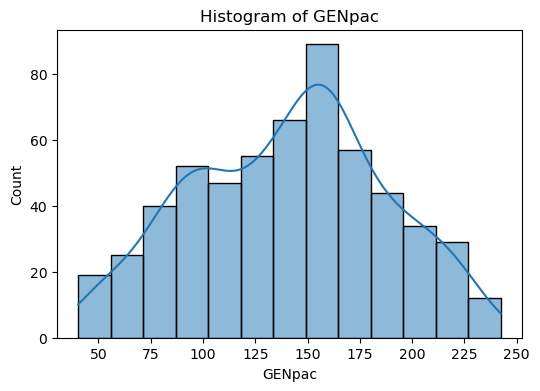

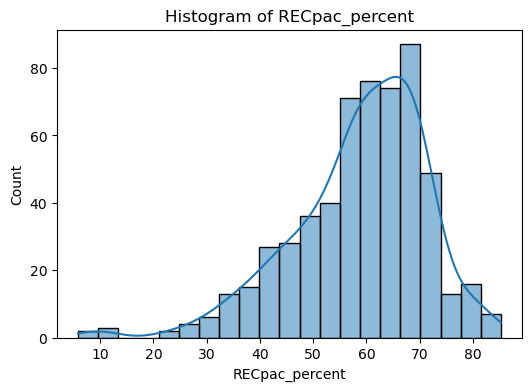

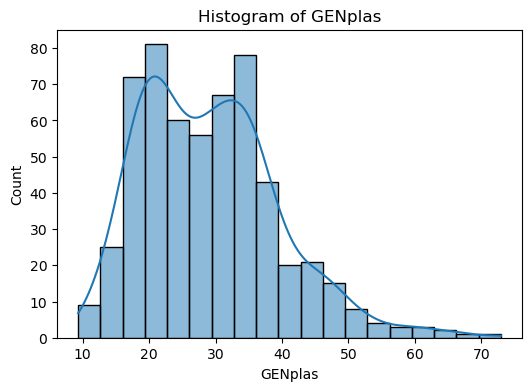

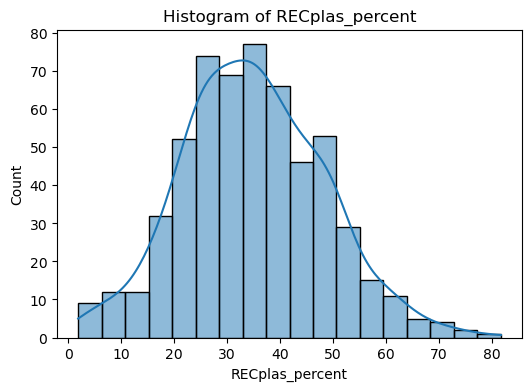

In [15]:
#visualize the variables to check distribution

#visualize rhe following columns except for country and year in df_pac with a histogram
# (GENpac, RECpac, GENplas, RECplas)
cols_pac = ['GENpac', 'RECpac_percent', 'GENplas', 'RECplas_percent']
for col in cols_pac:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_pac[col], kde=True)
    plt.title(f'Histogram of {col}')

In [21]:
# Very surprised to see that there were countries that recycled up to 80% of their plastic packaging waste.
# check who it was.

max_rec_pac = df_pac.loc[df_pac['RECpac_percent'].idxmax()]
max_rec_plas = df_pac.loc[df_pac['RECplas_percent'].idxmax()]
print("Max RECpac_percent details:", max_rec_pac)
print("Max RECpac_percent details:", max_rec_plas)

Max RECpac_percent details: country              Belgium
year                    2018
GENpac                157.51
RECpac                134.31
GENplas                 30.4
RECplas                 12.9
RECpac_percent     85.270776
RECplas_percent    42.434211
Name: 48, dtype: object
Max RECpac_percent details: country             Slovenia
year                    2013
GENpac                 97.28
RECpac                 67.09
GENplas                20.41
RECplas                16.68
RECpac_percent     68.965872
RECplas_percent    81.724645
Name: 799, dtype: object


In [ ]:
# check skewness and kurtosis to see if normalization is needed

dist_summary_pac = {} 

for col in cols_pac:
    dist_summary_pac[col] = {
        'skew': skew(df_pac[col].dropna()),
        'kurtosis': kurtosis(df_pac[col].dropna())
    }

dist_summary_pac = pd.DataFrame(dist_summary_pac).T
dist_summary_pac

# rule of thumb: 

# ---skew < abs(0.5): no transformation needed
# ---abs(0.5) < skew < abs(1.0): mild skew, consider transformation if important
# --- abs(1) < skew: strong skew, recommend transformation

# --- kurtosis < abs(1): close to normal
# --- abs(1) < kurtosis < abs(2): moderate tails
# --- abs(2) < kurtosis: heavy tails, outliers likely


# mild skewness, but not too bad. No transformation needed.

,skew,kurtosis
GENpac,-0.074061,-0.705366
RECpac_percent,-0.933887,1.450695
GENplas,0.794498,0.802697
RECplas_percent,0.215708,0.094032


Text(0.5, 1.0, 'Generated and Recycled Packaging Waste (Aggregate)')

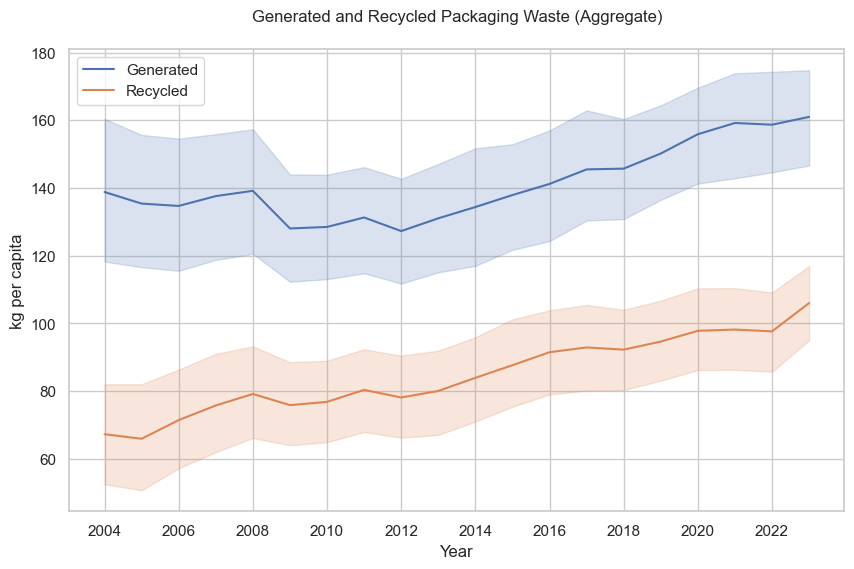

In [28]:
# visualize the time trend of GENpac and RECpac

sns.set_theme(style = 'whitegrid')

#set dpi to 600
#plt.rcParams['figure.dpi'] = 600

#line plot of GENpac and RECpac on the y axis and year on the x axis
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='GENpac', data=df_pac, label='Generated')
sns.lineplot(x='year', y='RECpac', data=df_pac, label='Recycled')

#tick marks on x-axis is every two years
plt.xticks(df_pac['year'].unique()[::2])
plt.xlabel('Year')
plt.ylabel('kg per capita')
plt.title('Generated and Recycled Packaging Waste (Aggregate)', pad = 20)

Text(0.5, 0, 'Year')

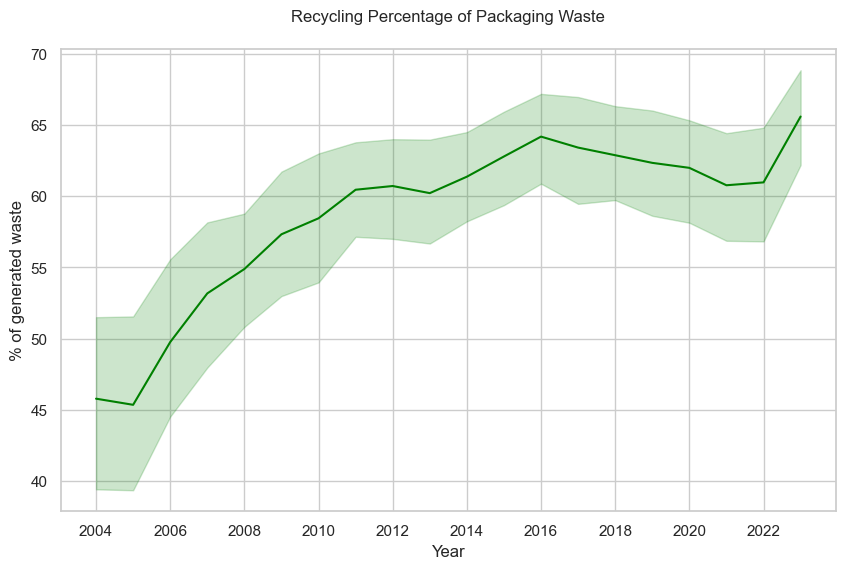

In [29]:
#create a plot for RECpac_percent
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='RECpac_percent', data=df_pac, color = 'green')

plt.xticks(df_pac['year'].unique()[::2])
plt.title('Recycling Percentage of Packaging Waste', pad = 20)
plt.ylabel('% of generated waste')
plt.xlabel('Year')

Text(0.5, 1.0, 'Generated and Recycled Packaging Waste (Plastic)')

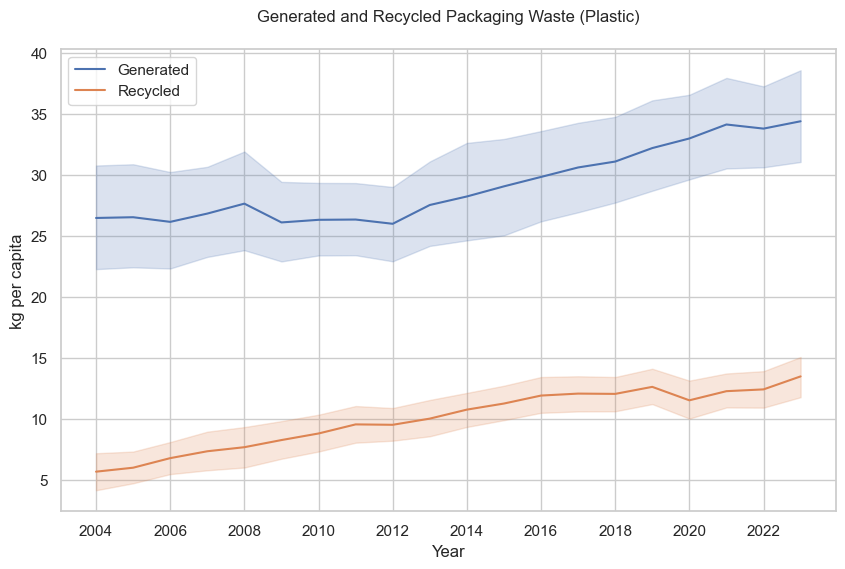

In [ ]:
#plot th same chart for GENplas and RECplas
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='GENplas', data=df_pac, label='Generated')
sns.lineplot(x='year', y='RECplas', data=df_pac, label='Recycled')

#tick marks on x-axis is every two years
plt.xticks(df_pac['year'].unique()[::2])
plt.xlabel('Year')
plt.ylabel('kg per capita')
plt.title('Generated and Recycled Packaging Waste (Plastic)', pad = 20)


Text(0.5, 1.0, 'Percentage of Recycled Plastic Packaging')

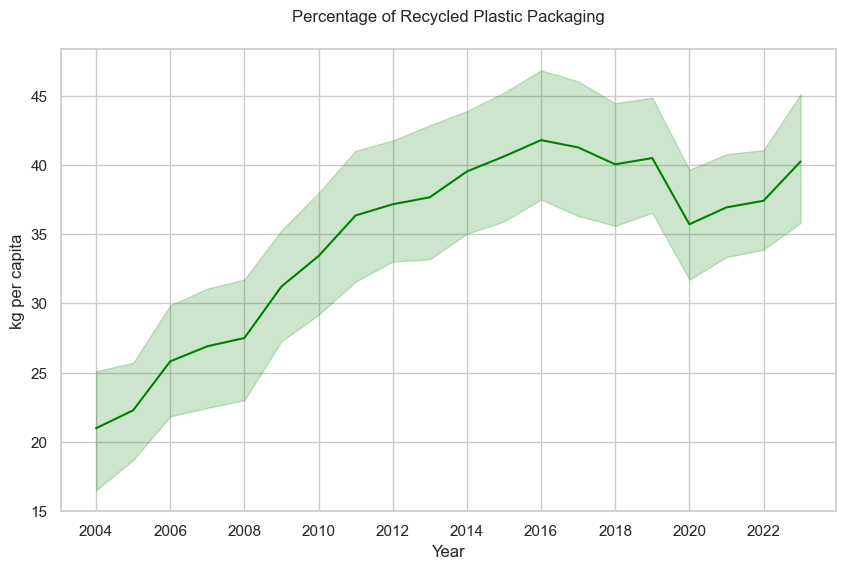

In [31]:
#create a new column RECplas_percent
df_pac['RECplas_percent'] = df_pac['RECplas'] / df_pac['GENplas'] * 100

#plot it
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='RECplas_percent', data=df_pac, color = 'green')
plt.xticks(df_pac['year'].unique()[::2])
plt.xlabel('Year')
plt.ylabel('kg per capita')
plt.title('Percentage of Recycled Plastic Packaging', pad = 20)